## Example: Local Density of States Maximization

In this example, we will show how to compute limits on the local density of states using the dolphindes package. The LDOS is defined as 

$$
f_\textrm{LDOS}(\bm P) \equiv -\dfrac{1}{2} \Re\bm j_i^\dagger \bm e = -\dfrac12 \Re\left( \bm j_i^\dagger \mathbb{G}_0 \left( \dfrac{i}{\omega} \bm j_i + \bm p \right) \right) = \underbrace{-\dfrac{1}{2} \Re\left(\bm e_i^\dagger  \bm j_i \right)}_{\rho_{vac}} - \underbrace{\dfrac{1}{2} \Re\left( i\omega \bm e_i \bm p \right)}_{\rho}.
$$

This is a common way to formulate objectives for limits: expand the electric field into its incident and scattered parts, giving the optimization variable $\bm p$. Here, we used the fact that the phase of $\bm j_i$ is irrelevant so we can take $\bm j_i$ to be real so that $\bm j_i \mathbb{G}_0 = \bm e_i$.

We will compute $\rho_0$ (LDOS in vacuum) as it is a constant. Then we will bound $\rho$. To do so, we need to define the quadratic and linear components of the objective. The quadratic component is zero, so we will pass $A_0 = 0$ to the photonics solver. For defining objectives, the optimizer will take $\bm s_0$ and add $2 \Re (\bm p^\dagger \bm s_0)$ to the objective. Thus, we define the linear term 
$$
\bm s_0 = -\frac14 i \omega \bm e_i^*.
$$

There is one additional detail. This objective is fine as is for the dense formulation. We will be using the sparse formulation, where $\mathbb{G}_0 \bm p$ is the degree of freedom instead of $\bm p$. This leverages the sparsity of $\mathbb{G}_0^{-1}$ (proportional to the sparse Maxwell operator). Thus, we need to take all $\bm p \to \mathbb{G}_0^{-1} \bm p$. The final linear term is
$$
\bm s_0 = -\frac14 i \omega \mathbb{G}_0^{-\dagger} \bm e_i^*.
$$

The photonics class will calculate this Green's function for you.

A note on optimization: in this notebook, we use BFGS with global constraints (projectors are identity matrices) and show how to utilize projector refinemenets to tighten limits. For fancier methods (Newton, Generalized Constraint Descent), see other tutorials. 

This example is 2D TM FDFD, but can be generalized to TE (or in theory 3D)

In [1]:
#TODO(alessio): Re-write this example once photonics is finalized.

%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time, os

package_path = os.path.abspath('../../../dolphindes')
if package_path not in sys.path:
    sys.path.append(package_path)

from dolphindes import photonics

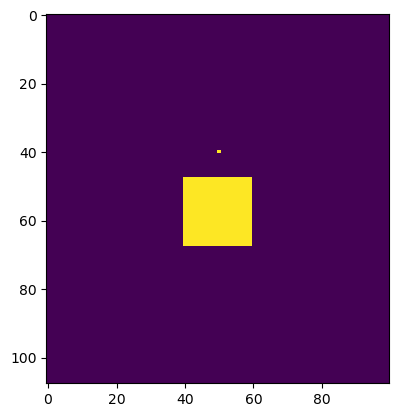

In [17]:
# First, let's define the relevant parameters for the simulation. 

wavelength = 1.0 # Dolphindes uses dimensionless units. 
omega = 2 * np.pi / wavelength
chi = 4+1e-4j # Design material 
px_per_length = 40 # pixels per length unit. If wavelength = 1.0, then this is pixels per wavelength.
dl = 1/px_per_length 
Npmlsep = int(0.5 / dl) # gap between design region and PML. Not required to be defined, it is just convenient.
Npmlx, Npmly = int(0.5 / dl), int(0.5 / dl) # PML size.
Mx, My = int(0.5 / dl), int(0.5 / dl) # design mask size 
Dx = int(0.2 / dl) # distance from the design region to the source region.
Nx, Ny = int(Npmlx*2 + Npmlsep*2 + Dx + Mx), int(Npmly*2 + Npmlsep*2 + My) # grid size. This includes the pml layer!

cx, cy = Npmlx + Npmlsep, Ny//2

ji = np.zeros((Nx, Ny), dtype=complex) # current density
ji[cx, cy] = 1.0/dl/dl # a delta function source in 2D is approximated by amplitude 1/dl/dl so that integration int(ji)dxdy = 1.0. 
design_mask = np.zeros((Nx, Ny), dtype=bool) # design mask
design_mask[Npmlx + Npmlsep + Dx: Npmlx + Npmlsep + Dx + Mx, Npmly + Npmlsep: Npmly + Npmlsep + My] = True # design mask
ndof = np.sum(design_mask) # number of degrees of freedom in the design region

chi_background = np.zeros((Nx, Ny), dtype=complex) # background material
chi_background[:, :] = 0

plt.imshow(design_mask + np.real(ji)*dl*dl) # visualize where the mask and the source are

Vacuum LDOS:  0.7878293286311646


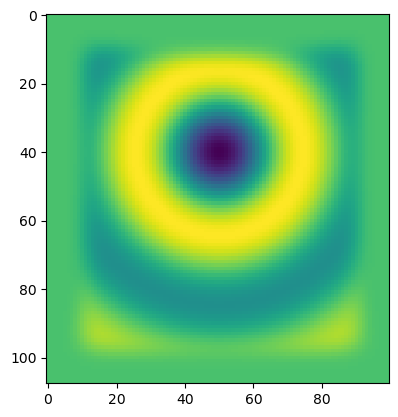

In [18]:
# Let's now initiate the photonics TM FDFD class. Leave the objective empty for now, let's use the class to compute the source field first. 
ldos_problem = photonics.Photonics_TM_FDFD(omega = omega, chi=chi, Nx = Nx, Ny = Ny, Npmlx = Npmlx, Npmly = Npmly, dl = dl,
    des_mask = design_mask, ji=ji, chi_background=chi_background, sparseQCQP=True, A0=None, s0=None, c0=0.0)
ldos_problem.setup_FDFD()
ei = ldos_problem.FDFD.get_TM_field(ji)

ldos_problem.setup_EM_operators()
Ginv = ldos_problem.Ginv 

plt.imshow(np.real(ei))

vac_ldos = -np.sum(1/2 * np.real(ji.conj() * ei) * dl * dl)
print("Vacuum LDOS: ", vac_ldos)

In [19]:
# Now let's set s0. We need to restrict ei to the design region. 
ei_design = ei[ldos_problem.des_mask] # restrict the field to the design region
s0 = - (1/4) * 1j * omega * Ginv.T.conj() @ ei_design.conj() * dl * dl
ldos_problem.s0 = s0
ldos_problem.A0 = sp.csc_array(np.zeros((ndof, ndof), dtype=complex))


In [20]:
# We are ready to set up the QCQP. 
ldos_problem.setup_QCQP(Pdiags = 'global', verbose=1) # verbose has a few levels. 0 is silent, 1 is basic output, 2 is more verbose, 3 is very verbose.
result = ldos_problem.QCQP.solve_current_dual_problem(method='bfgs', init_lags = None)
print(f'bound is {result[0]}')
print(f'bound on enhancement is {(result[0] + vac_ldos)/vac_ldos}')

Precomputed 2 A matrices for the projectors.
Found feasible point for dual problem: [3.61514231e-07 1.00000000e-01] with dualvalue 155.49329807191867
bound is 0.5890881659276921
bound on enhancement is 1.7477357652465404


### Iterative Splitting
Iterative splitting is a way to add constraints to the bounds problem without changing the dual value. For example, if we have projector $P=[1,1]$ with multiplier $\lambda = 1$, we can split it into two projectors $P_1 = [1,0]$ and $P_2 = [0,1]$ with multipliers $\lambda_1 = 1$ and $\lambda_2 = 1$. The dual value remains the same, but now both multipliers may be optimized independently, tightening the bounds.

Iterative splitting consists of two steps: the projector refinement, and the new optimization. We do this in a loop to successively tighten the bounds.

In [ ]:
results = [] 
result_counter = 0
for result in ldos_problem.QCQP.iterative_splitting_step():
    result_counter += 1
    num_constr = ldos_problem.QCQP.get_number_constraints()
    print(f'at step {result_counter}, number of constraints is {num_constr}, bound is {result[0]}')

    results.append((num_constr, result[0]))
    # Perform saving, break condition, etc.

    
    if result_counter > 0:
        assert results[result_counter-1][1] >= result[0], "Iterative splitting step must decrease dualval."

    if ldos_problem.Pdiags.shape[1] > 200: # break condition to run this quickly. You may continue until the end of the loop: the generator will eventually return.
        break

print(results)


Splitting projectors: 2 → 2
at step 0, number of constraints is 6, bound is 0.5675882463718327
Splitting projectors: 6 → 10
at step 1, number of constraints is 10, bound is 0.538303080635849
Splitting projectors: 10 → 18
at step 2, number of constraints is 18, bound is 0.5212770697516986
Splitting projectors: 18 → 34
at step 3, number of constraints is 34, bound is 0.5127183133905597
Splitting projectors: 34 → 66
at step 4, number of constraints is 66, bound is 0.49276869229798814
Splitting projectors: 66 → 130
at step 5, number of constraints is 130, bound is 0.44715803788580094
Splitting projectors: 130 → 258


AssertionError: Dual value should be the same after refinement.